In [1]:
import pandas as pd
from collections import defaultdict
import dvc.api
from tqdm import tqdm

In [2]:
df_original = pd.read_csv(dvc.api.get_url('datasets/data/wish_attr_extract_label/appen/input_batch_processed/appen_product_attribution_batch1.csv', 
    repo='git@github.com:ContextLogic/multitask-llm-rnd.git'))

In [3]:
!ls appen/output_batch_correct_v2

product_attribution_02.03.23.csv  product_attribution_02.03.23.csv.dvc


In [4]:
df = pd.read_csv('appen/output_batch_correct_v2/product_attribution_02.03.23.csv')

In [5]:
len(df)

20544

In [6]:
df_merge = df_original[['title', 'category_path', 'product_id', 'label_ordering']].rename(columns={'product_id': 'Product_Id', 'title': 'title_original', 
        'category_path': 'category_path_original', 'label_ordering': 'label_ordering_original'}).merge(df[[
    'Product_Id', 'Title', 'Product_Category', 'Label_Ordering'
]])

In [7]:
(df_merge['label_ordering_original'].astype(int) == df_merge['Label_Ordering'].astype(int)).all()

True

In [8]:
(df_merge['title_original'].str.strip() != df_merge['Title'].str.strip()).mean()

0.0

In [10]:
import numpy as np

In [11]:
df = pd.read_csv('appen/output_batch_correct_v2/product_attribution_02.03.23.csv')
errors = []
correct = []
empty = []
for i in tqdm(df[['Label_Ordering', 'Title', 'Product_Description', 'Final Answer', 'Product_Category']].to_dict('records')):
    res = [] if ((not isinstance(i['Final Answer'], str)) and (np.isnan(i['Final Answer']))) else i['Final Answer'].split('\n')
    if len(res) == 0:
        empty.append(i)
    is_correct = True
    for j in res:
        if not j.startswith(i['Product_Category']):
            errors.append(i)
            is_correct = False
            break
    if is_correct:
        correct.append(i)
len(correct) / len(df), len(errors) / len(df), len(empty) / len(df)

100%|██████████| 20544/20544 [00:00<00:00, 285694.61it/s]


(0.8871690031152648, 0.1128309968847352, 0.15736954828660435)

<AxesSubplot: ylabel='Product_Category_L2'>

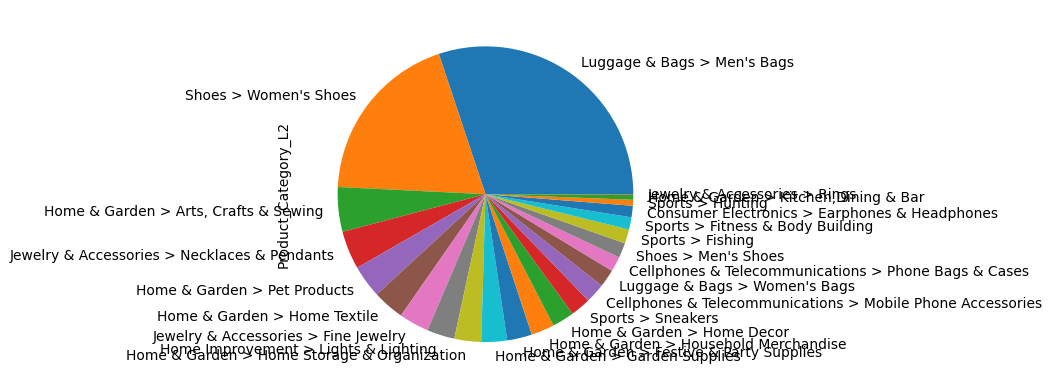

In [12]:
df_errors = pd.DataFrame(errors)
df_errors['Product_Category_L2'] = df_errors['Product_Category'].apply(lambda x: ' > '.join(x.split(' > ')[:2]))
df_errors['Product_Category_L2'].value_counts().plot.pie()

# find unusable data

In [2]:
df = pd.read_csv('appen/output_batch_correct_v2/product_attribution_02.03.23.csv')

In [3]:
df_attributes = pd.read_csv('../attribute_extraction_metadata_template/attribute_definition_top25L2_filtered_augmented_redacted_addedsinglemulti_01182023.csv')

In [4]:
from functools import reduce

In [5]:
df_attributes_group = df_attributes.groupby('attribute_field').agg({
    'category_attributevalue': lambda x: reduce(lambda x, y: x+y, [eval(i) for i in x])
}).reset_index()

In [6]:
len(df_attributes_group), df_attributes_group.category_attributevalue.apply(len).sum()

(230, 516378)

In [7]:
attributes = set(df_attributes_group['attribute_field'])

In [10]:
import numpy as np

In [11]:
correct = []
errors = []
empty = []
for i in df.to_dict('records'):
    res = [] if ((not isinstance(i['Final Answer'], str)) and (np.isnan(i['Final Answer']))) else i['Final Answer'].split('\n')
    if len(res) == 0:
        empty.append(i)
    is_correct = True
    for j in res:
        if len(j.split(' > ')) < 2:
            i['explanation'] = f"{j} has no attribute name"
            errors.append(i)
            is_correct = False
            break
        if j.split(' > ')[-2] not in attributes:
            i['explanation'] = f"{j} has invalid attribute name, because {j.split(' > ')[-2]} is not a valid attribute name"
            errors.append(i)
            is_correct = False
            break
    if is_correct:
        correct.append(i)
len(df), len(correct), len(errors), len(empty), len(correct) + len(errors)

(20544, 19679, 865, 3233, 20544)

In [19]:
len(correct) - len(empty)

16446

In [20]:
len(empty) / len(df), (len(correct) - len(empty)) / len(df), len(errors)/len(df)

(0.15736954828660435, 0.8005257009345794, 0.0421047507788162)

In [13]:
df_correct = pd.DataFrame(correct)
df_error = pd.DataFrame(errors)

In [16]:
df_correct[['Title', 'Final Answer']].sample(2).to_dict('records')

[{'Title': 'Brown and Blue Classic Bathroom Rules Framed Wall Art',
  'Final Answer': 'Home & Garden > Home Decor > Ornaments > Decorative Boards > Materials > Canvas\nHome & Garden > Home Decor > Ornaments > Decorative Boards > Materials > Wood'},
 {'Title': 'Newly style 7-8mm Fashion bla cultured pearl making charms nelace 84" MY4554  ',
  'Final Answer': 'Jewelry & Accessories > Necklaces & Pendants > Torques > Size > 7\nJewelry & Accessories > Necklaces & Pendants > Torques > Size > 8\nJewelry & Accessories > Necklaces & Pendants > Torques > Primary Color > Black\nJewelry & Accessories > Necklaces & Pendants > Torques > Main Stone > Pearl'}]

In [18]:
df_error.to_csv('appen/output_batch_correct_v2/feedback/product_attribution_02.03.23_invalid_units_02.21.23.csv')
df_correct.to_csv('appen/output_batch_correct_v2/feedback/product_attribution_02.03.23_valid_units_02.21.23.csv')